In [106]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from renormalization_hp import *

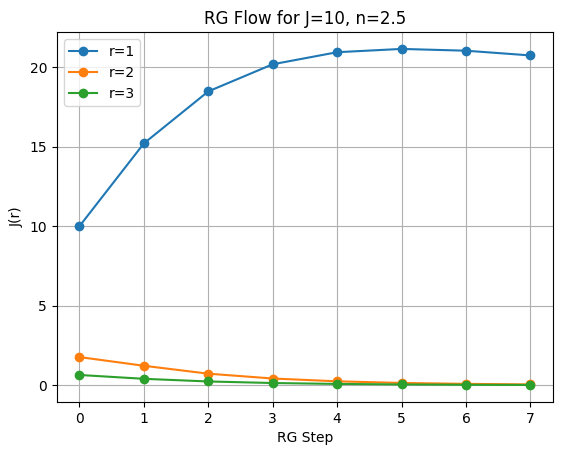

CPU times: user 1min 38s, sys: 241 ms, total: 1min 38s
Wall time: 1min 38s


In [189]:
%%time

generate_rg_flow(
    J0=10, n=2.5,
    max_k=5000, num_steps=7,
    show_first=0, num_r_to_plot=3
)

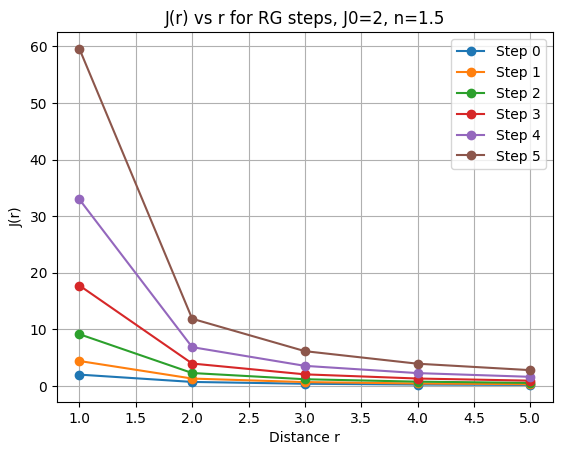

In [58]:
plot_rg_steps_vs_r(
    J0=2, n=1.7,
    max_k=22000, num_steps=10, plot_up_to_r=5
)

In [195]:
def find_J_c(n, max_k=1000, tol=1e-6, J_low=1e-6, J_high=3.0):
    """
    Finds the critical J_c for the given n using binary search and RG flow simulation.
    
    This function performs a binary search to find the critical coupling J_c where the 
    renormalization group (RG) flow transitions between growing and decaying for the 
    interaction J(d) = J0 / d^n. It simulates the RG flow and checks the behavior of 
    the coupling at r=2 after a minimum number of steps to avoid initial fluctuations.
    
    Parameters:
    n (float): The exponent in the power-law interaction. Must be 0 < n < 2.
    max_k (int): Maximum distance r to consider in the RG flow.
    tol (float, optional): Tolerance for the binary search convergence. Default is 1e-6.
    J_low (float, optional): Lower bound for binary search. Default is 0.0.
    J_high (float, optional): Upper bound for binary search. Default is 3.0.
    
    Returns:
    mp.mpf: The critical J_c value.
    
    Raises:
    ValueError: If n is not in (0, 2) or max_k is too small.
    """
    # Check if n is within the allowed range (0 < n < 2)
    if n <= 0 or n >= 2:
        raise ValueError("n must be between 0 and 2, excluding the edges.")
    
    start_track = 3  # Start checking after 3 RG steps to avoid initial fluctuations
    max_steps = 5   # Maximum number of RG steps to perform
    tol = mp.mpf(tol)
    J_low = mp.mpf(J_low)
    J_high = mp.mpf(J_high)
    min_max_k = 2  # Since we only need at least r=2
    if max_k < min_max_k:
        raise ValueError(f"max_k should be at least {min_max_k} for smooth and correct calculation with r=2")

    def compute_flow(J0):
        # Initialize J function for initial step
        J_func = lambda d: get_J(d, J0, n) if d > 0 else mp.mpf(0)
        rs = list(range(1, max_k + 1))
        all_Js = [[J_func(r) for r in rs]]  # Store J values at each step

        for step in range(1, max_steps + 1):
            Jps = []
            for r in rs:
                start = 3 * r + 1
                Jp = compute_J_prime_func(start, J_func)
                Jps.append(Jp)
            all_Js.append(Jps)

            # After start_track steps, check the change in J(r=2) from previous to current
            if step >= start_track:
                J_r2_current = Jps[1]  # J at r=2 (index 1)
                J_r2_previous = all_Js[-2][1]  # J at r=2 from previous step
                if J_r2_current > J_r2_previous:
                    return all_Js, True  # Growing (ferromagnetic)
                if J_r2_current < J_r2_previous:
                    return all_Js, False  # Decaying (paramagnetic)

            # Update J_func for the next step
            J_dict = {r: Jps[r-1] for r in rs}
            J_func = lambda d: J_dict.get(d, mp.mpf(0)) if d > 0 else mp.mpf(0)

        # Fallback if no decision within max_steps: compare initial and final J(r=2)
        J_r2_initial = all_Js[0][1]
        J_r2_final = all_Js[-1][1]
        return all_Js, J_r2_final > J_r2_initial

    # Binary search loop
    iter_count = 0
    while J_high - J_low > tol and iter_count < 100:
        iter_count += 1
        J_mid = (J_low + J_high) / 2
        all_Js, is_growing = compute_flow(J_mid)
        if is_growing:
            J_high = J_mid  # Growing: search lower half
        else:
            J_low = J_mid  # Decaying: search upper half
    return J_mid

def plot_J_c_vs_n(n_values, max_k=500, tol=1e-4):
    J_c_values = []
    min_max_k = 2  # Since we only need r=2
    if max_k < min_max_k:
        raise ValueError(f"max_k should be at least {min_max_k} for smooth and correct calculation with r=2")

    for n in n_values:
        try:
            J_c = find_J_c(n, max_k, tol, J_low=1e-3, J_high=3.0)
            J_c_values.append(1/float(J_c))
            print(f"For n={n}, J_c={J_c}")
        except ValueError as e:
            print(f"For n={n}, error: {e}")
            J_c_values.append(None)  # Append None for invalid n

    plt.figure()
    plt.plot(n_values, J_c_values, marker='o')
    plt.xlabel('n')
    plt.ylabel('$1/J_c$')
    plt.grid(True)
    plt.show()

In [ ]:
find_J_c(
    n=1.7, max_k=5000,
    tol=1e-4, J_low=0.001, J_high=3.0
)

In [ ]:
n_values = np.linspace(0.75, 1.95, 10)
plot_J_c_vs_n(n_values, max_k=5000, tol=1e-4)

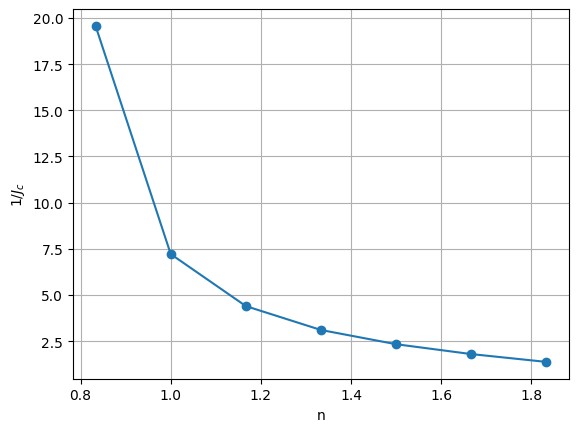

In [174]:
x = np.array([
[0.8333333333333333, 1/0.0510931732177734375047107148409],
[1.0,                1/0.138614669799804687504570904112],
[1.1666666666666665, 1/0.227417861938476562504429045946],
[1.3333333333333333, 1/0.322263333129882812504277535574],
[1.5,                1/0.428644064331054687504107598266],
[1.6666666666666665, 1/0.556081222534179687503904024485],
[1.8333333333333333, 1/0.727645327758789062]])

plt.figure()
plt.plot(x[:,0], x[:,1], marker='o')
plt.xlabel('n')
plt.ylabel('$1/J_c$')
plt.grid(True)
plt.show()

In [102]:
x = np.array([
[0.810204081632653,  1/0.028879119873046879],
[0.8693877551020407, 1/0.061211578369140617],
[0.9285714285714285, 1/0.09305599975585935],
[0.9877551020408162, 1/0.12477841186523436],
[1.046938775510204,  1/0.15625680541992182],
[1.1061224489795918, 1/0.18797921752929686],
[1.1653061224489796, 1/0.22018966674804685],
[1.2244897959183674, 1/0.25288815307617185],
[1.2836734693877552, 1/0.2863186950683593],
[1.3428571428571427, 1/0.32084732055664056],
[1.4020408163265305, 1/0.35659603881835933],
[1.4612244897959183, 1/0.39380886840820306],
[1.5204081632653061, 1/0.4329738464355469],
[1.579591836734694,  1/0.47421298217773433],
[1.6387755102040815, 1/0.5180143127441407],
[1.6979591836734693, 1/0.5648658752441406],
[1.7571428571428571, 1/0.615499725341797],
[1.816326530612245,  1/0.6706479187011717],
[1.8755102040816325, 1/0.7311645202636717],
[1.9346938775510203, 1/0.7985136413574219],
[1.993877551020408,  1/0.8744034118652343]])
#[2.0530612244897957, 1/0.9609079895019531]])

plt.figure()
plt.plot(x[:,0], x[:,1], marker='o')
plt.xlabel('n')
plt.ylabel('$1/J_c$')
plt.grid(True)
plt.show()